In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionfrom sklearn.model_selection import cross_val_score

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# imports

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
# load data

train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df  = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# missing values and overview

print(train_df.isna().sum(),"\n")

train_df.describe()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# explore

print(train_df["Embarked"].value_counts(normalize=True),"\n")

train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
family_size = train_df["FamilySize"]
big_fam = train_df[train_df["FamilySize"] >= 4].shape[0]
print(train_df["FamilySize"].describe())
print(f"Families with 4 or more: {big_fam}")

Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64 

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: FamilySize, dtype: float64
Families with 4 or more: 91


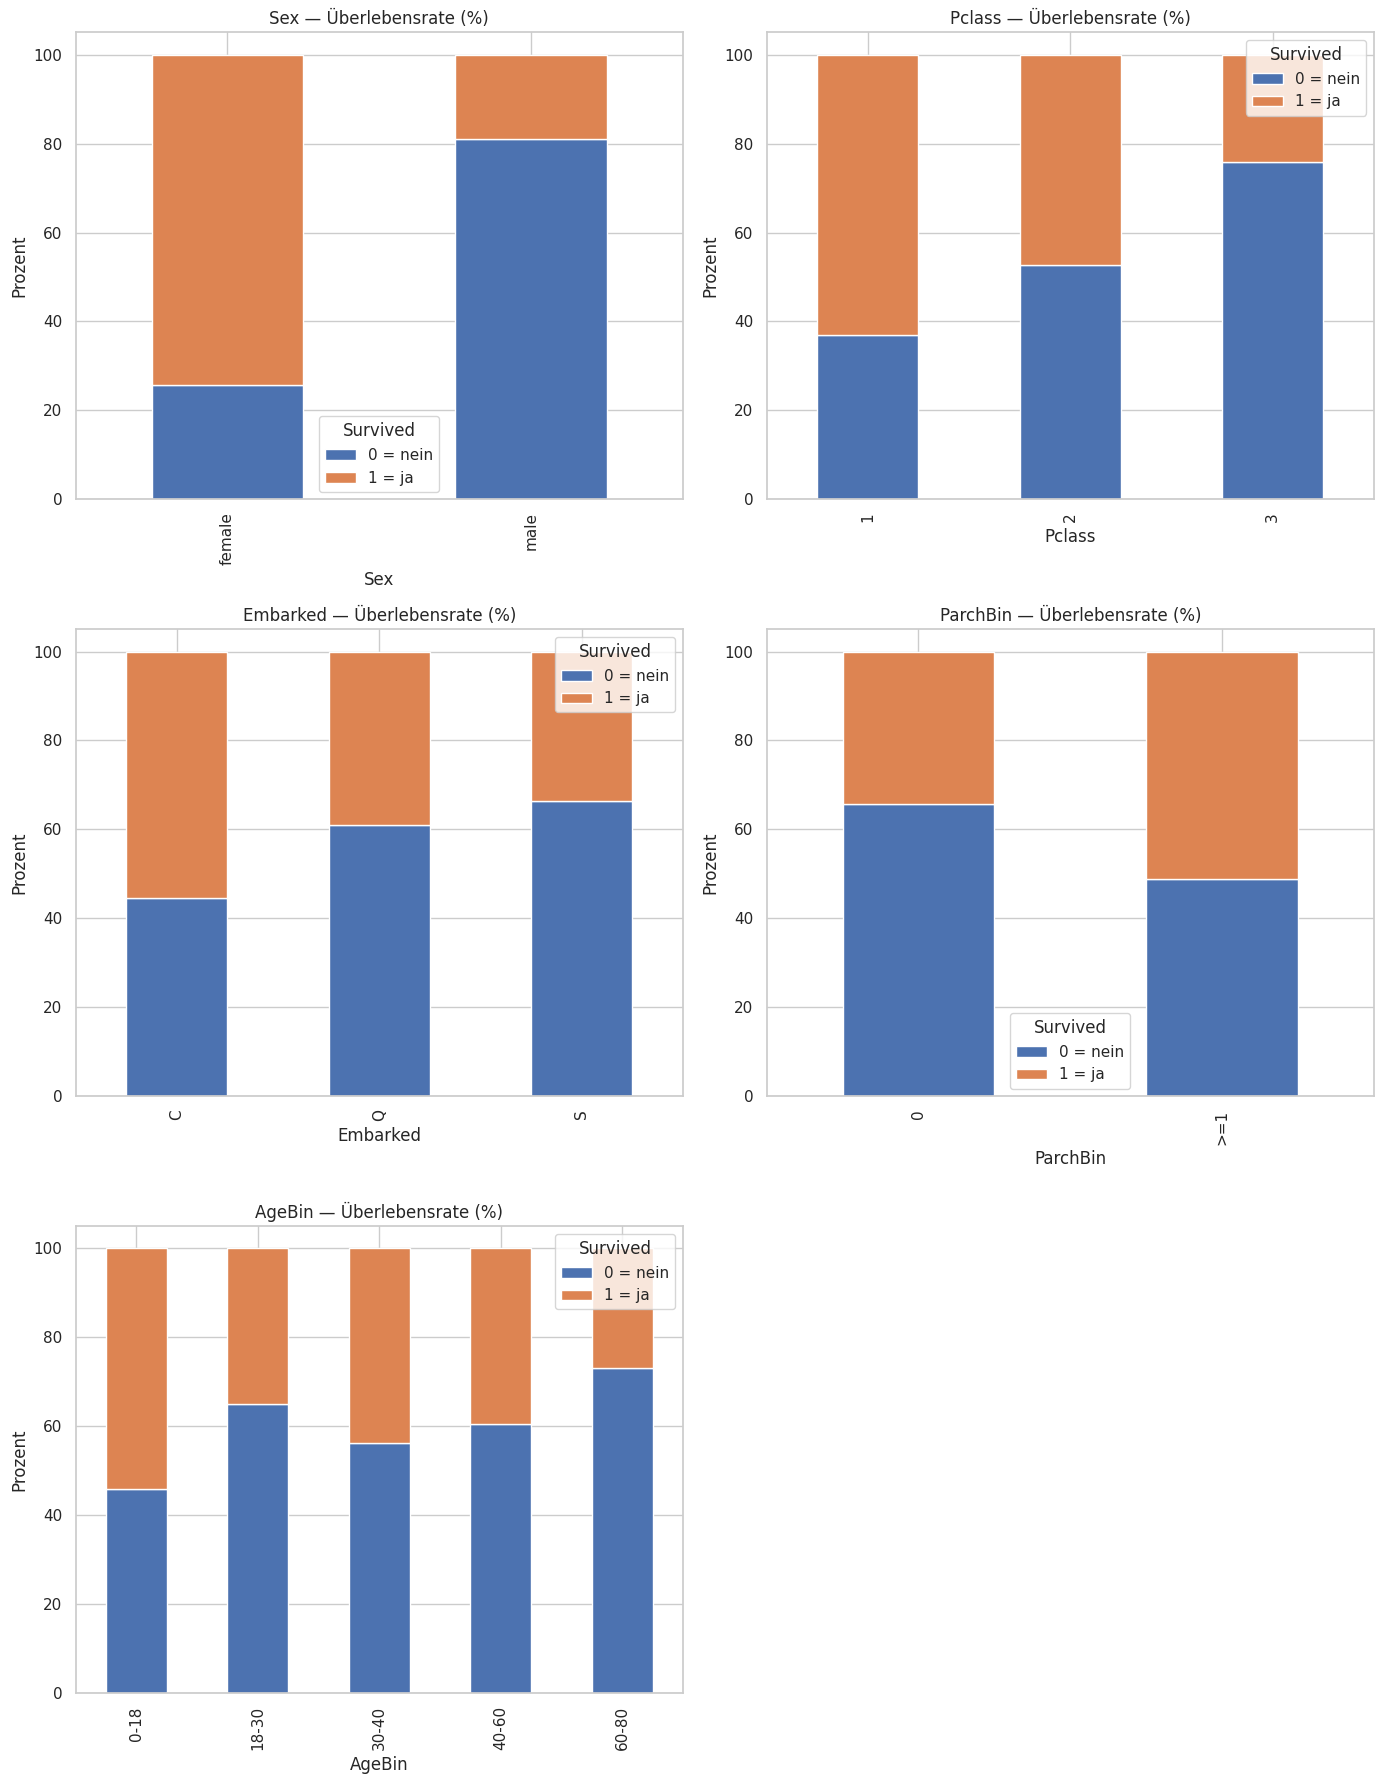

In [6]:
# survival plots
# Überlebensrate nach Merkmalen

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# ---- Age binnings ----
bins = [0, 18, 30, 40, 60, 81]
labels = ["0-18", "18-30", "30-40", "40-60", "60-80"]
train_df["AgeBin"] = pd.cut(train_df["Age"], bins=bins, labels=labels, right=False)

# ---- Parch binning 0 vs >=1 ----
train_df["ParchBin"] = np.where(train_df["Parch"] == 0, "0", ">=1")

# ---- Spalten definieren ----
plot_cols = ["Sex", "Pclass", "Embarked", "ParchBin", "AgeBin"]

# ---- 2 Plots pro Zeile ----
fig, axes = plt.subplots(nrows=(len(plot_cols)+1)//2, ncols=2, figsize=(14, 18))
axes = axes.flatten()

for ax, col in zip(axes, plot_cols):
    ct = pd.crosstab(train_df[col], train_df["Survived"], normalize="index") * 100
    ct.plot(kind="bar", stacked=True, ax=ax)

    ax.set_title(f"{col} — Überlebensrate (%)")
    ax.set_ylabel("Prozent")
    ax.legend(title="Survived", labels=["0 = nein", "1 = ja"])

for i in range(len(plot_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [7]:
# Feature Engeneering

for df in [train_df, test_df]:
    df["Deck"] = df["Cabin"].astype(str).str[0]
    df["Deck"] = df["Deck"].replace("n", np.nan)
    df["Deck"] = df["Deck"].fillna("Unknown")

    # FamilySize
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    # IsAlone
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

In [8]:
# Zielvariable
y = train_df["Survived"]

# Features
feature_cols = [
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked",
    "Deck",
    "FamilySize",
    "IsAlone",
]

X = train_df[feature_cols]
X_test = test_df[feature_cols]

In [9]:
# preprocessing pipeline

numeric_features = ["Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone"]
categorical_features = ["Pclass", "Sex", "Embarked", "Deck"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [10]:
# gridsearch

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [6, 8, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)

print("Beste Parameter:", grid.best_params_)
print("Beste Accuracy:", grid.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Beste Parameter: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Beste Accuracy: 0.8271671583704727


In [11]:
# get best model

best_rf_model = grid.best_estimator_

In [12]:
# cross validation

cv_scores = cross_val_score(
    best_rf_model,
    X,
    y,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("CV:", cv_scores)
print("Mean:", cv_scores.mean())

CV: [0.82122905 0.80337079 0.86516854 0.79775281 0.84831461]
Mean: 0.8271671583704727


In [13]:
# final submission best model

best_rf_model.fit(X, y)
test_pred = best_rf_model.predict(X_test)

In [14]:
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [15]:
# Feature importance best model

rf_clf = best_rf_model.named_steps["clf"]

ohe = best_rf_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_names = ohe.get_feature_names_out(categorical_features)
final_feature_names = np.concatenate([numeric_features, ohe_names])

importances = rf_clf.feature_importances_
fi_df = pd.DataFrame({
    "feature": final_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

importances = rf_clf.feature_importances_
fi_df = pd.DataFrame({
    "feature": final_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(20)

,feature,importance
10,Sex_male,0.209013
9,Sex_female,0.171174
3,Fare,0.148260
0,Age,0.139363
8,Pclass_3,0.062206
4,FamilySize,0.050034
22,Deck_Unknown,0.033855
1,SibSp,0.027718
6,Pclass_1,0.027573
2,Parch,0.023114


<Figure size 1000x800 with 0 Axes>

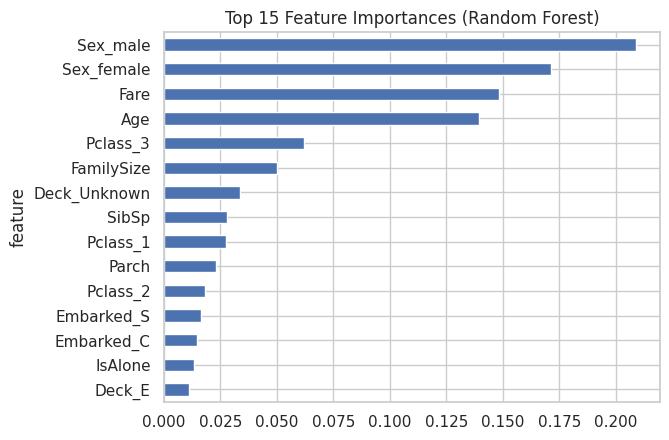

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
fi_df.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [17]:
# comparison log regression

lr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

lr_scores = cross_val_score(
    lr_model, X, y, cv=5, scoring="accuracy", n_jobs=-1
)

print(lr_scores.mean())

0.8024731655263324
